In [4]:
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sfp_nsdsyn.two_dimensional_model as two_d
import sfp_nsdsyn.cross_validation_2d_model as cv2d
import warnings
import json
import itertools

# Load the JSON file
with open("../config.json", "r") as file:
    config = json.load(file)
warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
dset='nsdsyn'
subj='subj01'
roi='V1'
vs='pRFsize'
max_epoch=30000
lr=0.0005
subj_list = ['subj01', 'subj02', 'subj03', 'subj04', 'subj05', 'subj06', 'subj07', 'subj08']
all_df = pd.DataFrame({})
for subj in subj_list:
    tmp = pd.read_csv(os.path.join(config['OUTPUT_DIR'],'sfp_model','cross_validation',f'{dset}',f'cvresults_bts-False_lr-{lr}_eph-{max_epoch}_sub-{subj}_roi-{roi}_vs-{vs}.h5'))
    tmp['sub'] = subj
    all_df = pd.concat([all_df, tmp], axis=0)

In [16]:
sample_df = all_df[['sub','fold','train_loss','test_loss','model_params']]

In [17]:
sample_df = all_df[['sub','fold','train_loss','test_loss','model_params']]
sample_df_long = sample_df.melt(id_vars=['sub','fold','model_params'], var_name='loss_type', value_name='loss')


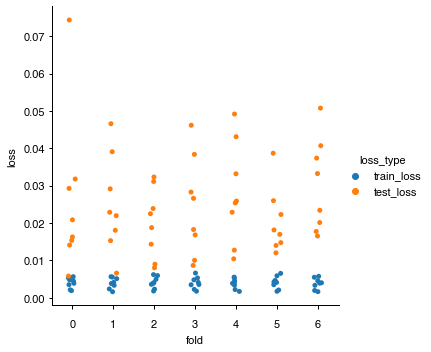

In [24]:
sns.catplot(data=sample_df_long, 
            x='fold', y='loss', hue='loss_type', kind='line', errorbar=('ci', 68))

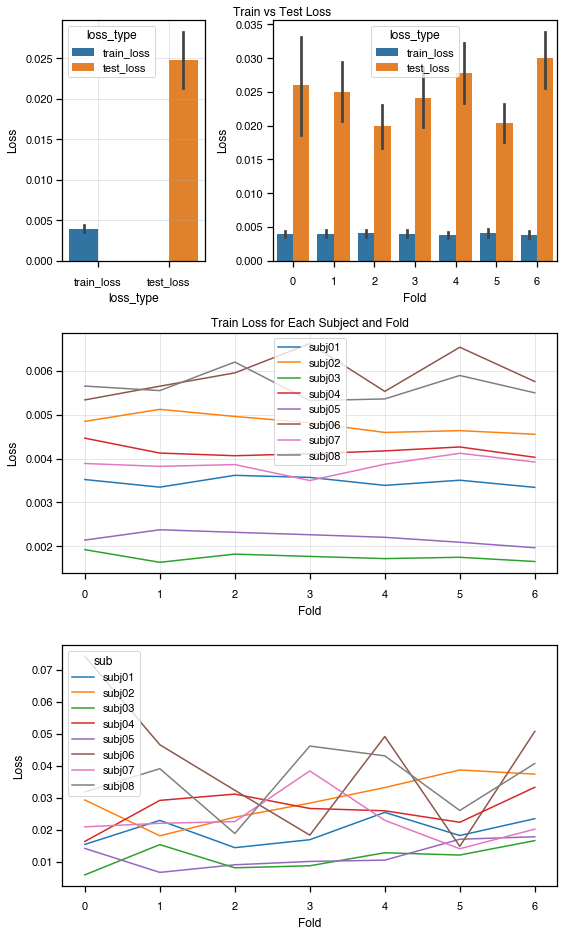

In [49]:
sample_df = all_df[['sub','fold','train_loss','test_loss','model_params']]

cv2d.plot_cv_results_group(sample_df)

In [ ]:
sns.lineplot(all_df, x='fold', y='train_loss', hue='sub')

In [110]:
sfp_model = two_d.SpatialFrequencyModel(full_ver=True)
cv_results, loss_history, model_history = cv2d.run_cross_validation(df, sfp_model, 
                                                                    n_folds=7, 
                                                                    n_test_classes=4, 
                                                                    learning_rate=1e-4, 
                                                                    max_epoch=1000, 
                                                                    print_every=100, 
                                                                    save_path=None, 
                                                                    loss_all_voxels=False, 
                                                                    random_state=42)


Fold 1/7
**epoch no.0 loss: 0.018
**epoch no.99 loss: 0.017
**epoch no.199 loss: 0.016
**epoch no.299 loss: 0.015
**epoch no.399 loss: 0.014
**epoch no.499 loss: 0.014
**epoch no.599 loss: 0.013
**epoch no.699 loss: 0.013
**epoch no.799 loss: 0.012
**epoch no.899 loss: 0.012
**epoch no.999 loss: 0.012
*epoch no.1000: Finished! final model params...
 {'sigma': 1.08, 'slope': 0.14, 'intercept': 0.26, 'p_1': 0.03, 'p_2': 0.08, 'p_3': 0.01, 'p_4': -0.0, 'A_1': 0.38, 'A_2': 0.25}
Elapsed time: 6.4 sec
Train loss: 0.0117
Test loss: 0.1105

Fold 2/7
**epoch no.0 loss: 0.012
**epoch no.99 loss: 0.011
**epoch no.199 loss: 0.011
**epoch no.299 loss: 0.011
**epoch no.399 loss: 0.01
**epoch no.499 loss: 0.01
**epoch no.599 loss: 0.01
**epoch no.699 loss: 0.01
**epoch no.799 loss: 0.009
**epoch no.899 loss: 0.009
**epoch no.999 loss: 0.009
*epoch no.1000: Finished! final model params...
 {'sigma': 1.17, 'slope': 0.14, 'intercept': 0.21, 'p_1': 0.06, 'p_2': 0.12, 'p_3': -0.08, 'p_4': 0.03, 'A_1': 0

In [115]:
pd.DataFrame(cv_results)

,fold,test_classes,train_loss,test_loss,train_losses_per_voxel,test_losses_per_voxel,model_params,loss_history,model_history
0,0,"[2, 27, 17, 23]",0.011732,0.110525,"[0.010403221667758396, 0.02212157959927155, 0....","[0.06231388710191897, 0.059433773628498075, 0....","{'sigma': 1.0777138471603394, 'slope': 0.14334...",epoch loss 0 0 0.017779 1 ...,epoch sigma slope intercept ...
1,1,"[11, 6, 18, 13]",0.008879,0.072563,"[0.00702393924019168, 0.013270993643876697, 0....","[0.10743504594326547, 0.22839525476996375, 0.1...","{'sigma': 1.1727997064590454, 'slope': 0.13649...",epoch loss 0 0 0.011997 1 ...,epoch sigma slope intercept ...
2,2,"[19, 21, 1, 5]",0.007628,0.040885,"[0.00763096208150934, 0.014042794839797777, 0....","[0.04227066649979824, 0.09562009595921737, 0.0...","{'sigma': 1.2691285610198975, 'slope': 0.17124...",epoch loss 0 0 0.009842 1 ...,epoch sigma slope intercept ...
3,3,"[26, 20, 25, 12]",0.006392,0.029914,"[0.006438959822186309, 0.012200555187368614, 0...","[0.010288166953848321, 0.01956511971595379, 0....","{'sigma': 1.3634053468704224, 'slope': 0.18112...",epoch loss 0 0 0.007990 1 ...,epoch sigma slope intercept ...
4,4,"[9, 3, 15, 22]",0.005831,0.020794,"[0.005970169168755916, 0.012004186864381731, 0...","[0.007055134282347268, 0.003354704208112449, 0...","{'sigma': 1.4575015306472778, 'slope': 0.18078...",epoch loss 0 0 0.006815 1 ...,epoch sigma slope intercept ...
5,5,"[4, 7, 24, 16]",0.005223,0.018843,"[0.005244170108771208, 0.010510916098466263, 0...","[0.00387319800633557, 0.00947224326519279, 0.0...","{'sigma': 1.5511988401412964, 'slope': 0.17733...",epoch loss 0 0 0.005944 1 ...,epoch sigma slope intercept ...
6,6,"[14, 8, 10, 0]",0.004677,0.025091,"[0.002932056160246801, 0.005467892554442018, 0...","[0.06229565092881347, 0.14376743585208407, 0.1...","{'sigma': 1.6440130472183228, 'slope': 0.18193...",epoch loss 0 0 0.005177 1 ...,epoch sigma slope intercept ...



CROSS-VALIDATION RESULTS
Mean training loss: 0.0070 ± 0.0020
Mean test loss: 0.0460 ± 0.0320
Mean generalization error: 0.0380


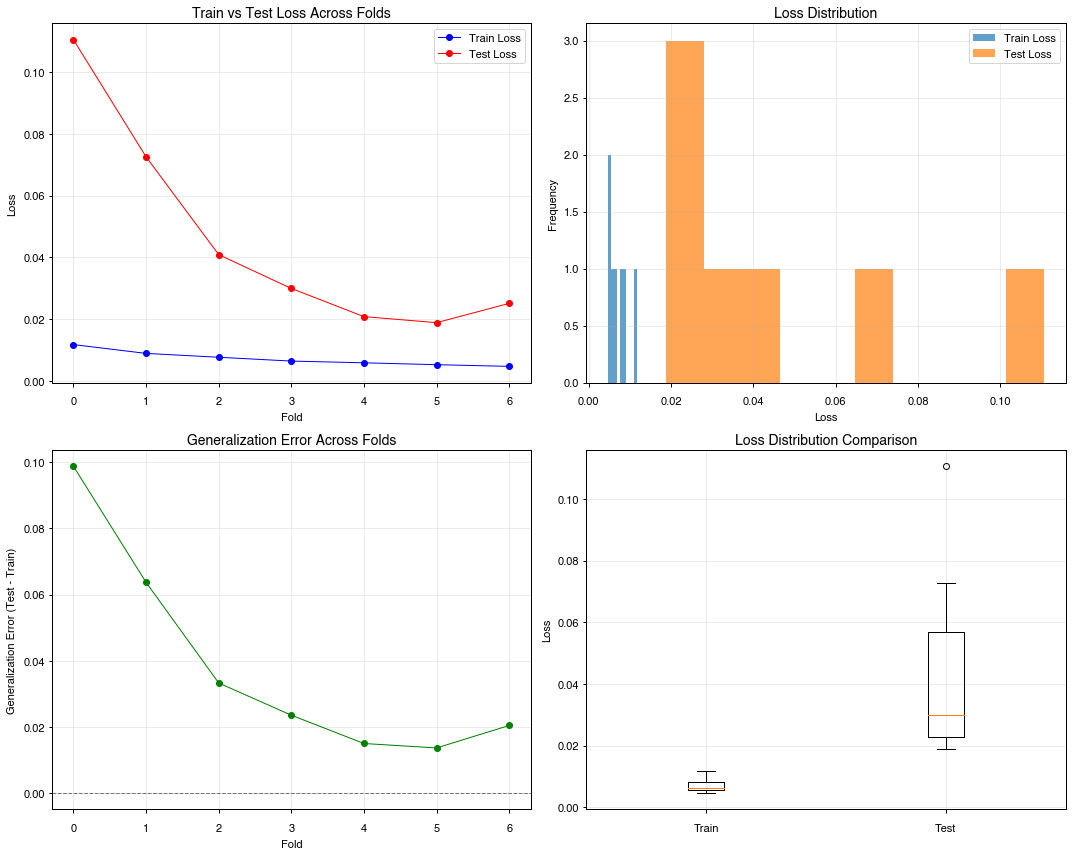

In [116]:
analysis = cv2d.analyze_cv_results(cv_results)
cv2d.plot_cv_results(cv_results, analysis)

In [54]:
test_df_avg.pivot('voxel','class_idx','betas')

class_idx,4,5,8,11
voxel,,,,
10,2.125417,1.882083,1.614583,1.170833
11,1.247083,1.139167,1.065000,0.703333
12,0.974583,1.111667,1.088750,0.361250
16,2.399167,2.051667,2.017917,1.439167
17,2.199167,1.725833,1.875000,1.142083
...,...,...,...,...
7086,0.857500,1.449583,1.500417,0.552500
7087,0.752083,1.480417,1.491250,0.526250
7089,0.751250,1.611250,1.628750,0.605417


In [58]:

# Evaluate on training data
train_loss, train_losses_per_voxel = cv2d.evaluate_model(
    subj_model, subj_dataset_train
)

# Evaluate on test data
test_loss, test_losses_per_voxel = cv2d.evaluate_model(
    subj_model, subj_dataset_test
)

# Store results
cv_results['fold'].append(fold + 1)
cv_results['test_classes'].append(test_classes)
cv_results['train_loss'].append(train_loss)
cv_results['test_loss'].append(test_loss)
cv_results['train_losses_per_voxel'].append(train_losses_per_voxel)
cv_results['test_losses_per_voxel'].append(test_losses_per_voxel)
#cv_results['model_params'].append(final_params)

print(f"Train loss: {train_loss:.4f}")
print(f"Test loss: {test_loss:.4f}")


Train loss: 0.0058
Test loss: 0.0856


In [48]:
subj_dataset_train.target.shape

torch.Size([2307, 24])